In [32]:
from music21 import instrument, converter
import music21
from datetime import datetime

from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K

import os
import numpy as np
from sklearn.model_selection import train_test_split

import random
from keras.models import load_model

import math



In [5]:
music21.environment.set('musescoreDirectPNGPath', 'C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe')
music21.environment.set('musicxmlPath', 'C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe')


In [68]:

music21.configure.run()


______________________________________________________________________________ 
  
Welcome the music21 Configuration Assistant. You will be guided through a 
number of questions to install and setup music21. Simply pressing return at a 
prompt will select a default, if available. 

You may run this configuration again at a later time by running 
music21/configure.py. 
  
______________________________________________________________________________ 
  
The BSD-licensed music21 software is distributed with a corpus of encoded 
compositions which are distributed with the permission of the encoders (and, 
where needed, the composers or arrangers) and where permitted under United 
States copyright law. Some encodings included in the corpus may not be used 
for commercial uses or have other restrictions: please see the licenses 
embedded in individual compositions or directories for more details. 
  
In addition to the corpus distributed with music21, other pieces are not 
included in this

In [111]:
checkpoint ="weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"


#specify the path
pathData='schubert/'
BATCH_SIZE = 256
nEpocas = 1000
steps_per_epoch = 10
VALIDATION_SIZE = 1


In [7]:
#defining function to read MIDI files
def read_midi(file):
    
    print("Loading Music File:",file)
    
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file
    midi = converter.parse(file)
  
    #grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)

    #Looping over all the instruments
    for part in s2.parts:
    
        #select elements of only piano
        if 'Piano' in str(part): 
        
            notes_to_parse = part.recurse() 
      
            #finding whether a particular element is note or a chord
            for element in notes_to_parse:
                
                #note
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                
                #chord
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

In [8]:


#read all the filenames
files=[i for i in os.listdir(pathData) if i.endswith(".mid")]

#reading each midi file
notes_array = np.array([read_midi(pathData+i) for i in files])

Loading Music File: schubert/schubert_D850_1.mid
Loading Music File: schubert/schubert_D850_2.mid
Loading Music File: schubert/schubert_D850_3.mid
Loading Music File: schubert/schubert_D850_4.mid
Loading Music File: schubert/schubert_D935_1.mid
Loading Music File: schubert/schubert_D935_2.mid
Loading Music File: schubert/schubert_D935_3.mid
Loading Music File: schubert/schubert_D935_4.mid
Loading Music File: schubert/schub_d760_1.mid
Loading Music File: schubert/schub_d760_2.mid
Loading Music File: schubert/schub_d760_3.mid
Loading Music File: schubert/schub_d760_4.mid
Loading Music File: schubert/schub_d960_1.mid
Loading Music File: schubert/schub_d960_2.mid
Loading Music File: schubert/schub_d960_3.mid
Loading Music File: schubert/schub_d960_4.mid
Loading Music File: schubert/schuim-1.mid
Loading Music File: schubert/schuim-2.mid
Loading Music File: schubert/schuim-3.mid
Loading Music File: schubert/schuim-4.mid
Loading Music File: schubert/schumm-1.mid
Loading Music File: schubert/s

In [9]:
#converting 2D array into 1D array
notes_ = [element for note_ in notes_array for element in note_]

#No. of unique notes
unique_notes = list(set(notes_))
print(len(unique_notes))

304


(array([187.,  40.,  27.,  11.,   6.,   9.,  12.,   6.,   3.,   3.]),
 array([1.0000e+00, 1.4810e+02, 2.9520e+02, 4.4230e+02, 5.8940e+02,
        7.3650e+02, 8.8360e+02, 1.0307e+03, 1.1778e+03, 1.3249e+03,
        1.4720e+03]),
 <a list of 10 Patch objects>)

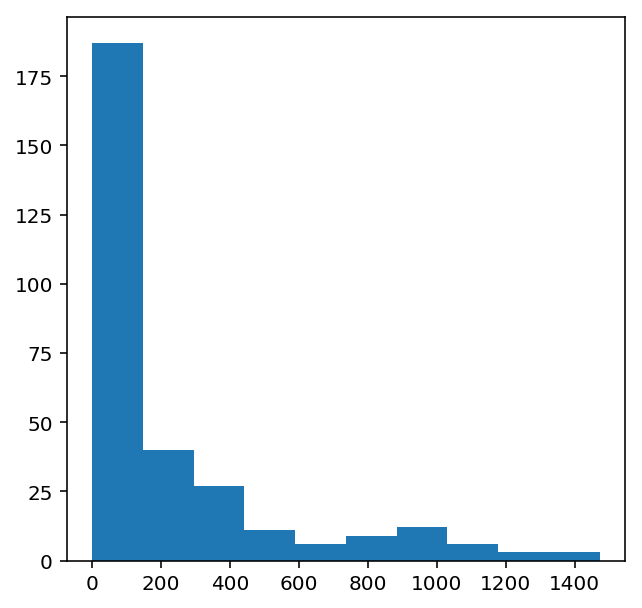

In [10]:
#importing library
from collections import Counter

#computing frequency of each note
freq = dict(Counter(notes_))

#library for visualiation
import matplotlib.pyplot as plt

#consider only the frequencies
no=[count for _,count in freq.items()]

#set the figure size
plt.figure(figsize=(5,5))

#plot
plt.hist(no)

In [11]:
frequent_notes = [note_ for note_, count in freq.items() if count>=50]
print(len(frequent_notes))

167


In [12]:
new_music=[]

for notes in notes_array:
    temp=[]
    for note_ in notes:
        if note_ in frequent_notes:
            temp.append(note_)            
    new_music.append(temp)
    
new_music = np.array(new_music)

In [13]:
no_of_timesteps = 32
x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timesteps, 1):
        
        #preparing input and output sequences
        input_ = note_[i:i + no_of_timesteps]
        output = note_[i + no_of_timesteps]
        
        x.append(input_)
        y.append(output)
        
x=np.array(x)
y=np.array(y)

In [14]:
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))

In [15]:
#preparing input sequences
x_seq=[]
for i in x:
    temp=[]
    for j in i:
        #assigning unique integer to every note
        temp.append(x_note_to_int[j])
    x_seq.append(temp)
    
x_seq = np.array(x_seq)

In [16]:
unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y)) 
y_seq=np.array([y_note_to_int[i] for i in y])

In [17]:

x_tr, x_val, y_tr, y_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=0)

In [100]:
def lstm():
    model = Sequential()
    model.add(Embedding(len(unique_x), 100, input_length=32,trainable=True)) 
    model.add(LSTM(128,return_sequences=True))
    model.add(LSTM(128))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(len(unique_y)))
    model.add(Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',  metrics = ['accuracy'])
    return model

In [95]:
def conv():
    model = Sequential()

    #embedding layer
    model.add(Embedding(len(unique_x), 100, input_length=32,trainable=True)) 

    model.add(Conv1D(64,3, padding='causal',activation='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPool1D(2))

    model.add(Conv1D(128,3,activation='relu',dilation_rate=2,padding='causal'))
    model.add(Dropout(0.2))
    model.add(MaxPool1D(2))

    model.add(Conv1D(256,3,activation='relu',dilation_rate=4,padding='causal'))
    model.add(Dropout(0.2))
    model.add(MaxPool1D(2))

    #model.add(Conv1D(256,5,activation='relu'))    
    model.add(GlobalMaxPool1D())

    model.add(Dense(256, activation='relu'))
    model.add(Dense(len(unique_y), activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
    return model


In [102]:

K.clear_session()
model = conv()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 100)           16700     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 64)            19264     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 64)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16, 128)           24704     
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 128)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 8, 128)            0         
__________

In [103]:
mc = ModelCheckpoint(checkpoint, monitor='loss', mode='min', save_best_only=True,verbose=1)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100, min_delta=0.000001)


In [107]:

compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / BATCH_SIZE))
val_steps = compute_steps_per_epoch(VALIDATION_SIZE)
val_steps

1

In [109]:
'''
history = model.fit(
    np.array(x_tr),
    np.array(y_tr),
    epochs=nEpocas, 
    steps_per_epoch=steps_per_epoch, 
    validation_steps=val_steps,
    validation_data=(np.array(x_val),np.array(y_val)),
    verbose=1, 
    callbacks=[es, mc])
'''

'\nhistory = model.fit(\n    np.array(x_tr),\n    np.array(y_tr),\n    epochs=nEpocas, \n    steps_per_epoch=steps_per_epoch, \n    validation_steps=val_steps,\n    validation_data=(np.array(x_val),np.array(y_val)),\n    verbose=1, \n    callbacks=[es, mc])\n'

In [112]:
history = model.fit(
    np.array(x_tr),
    np.array(y_tr),
    batch_size=BATCH_SIZE,
    epochs=nEpocas, 
    validation_data=(np.array(x_val),np.array(y_val)),
    verbose=1, 
    #callbacks=[es, mc]
)


Train on 51544 samples, validate on 12886 samples
Epoch 1/1000
51544/51544 [==============================] - 2s 44us/step - loss: 3.2061 - acc: 0.1761 - val_loss: 3.4125 - val_acc: 0.1700
Epoch 2/1000
51544/51544 [==============================] - 2s 43us/step - loss: 3.1574 - acc: 0.1831 - val_loss: 3.3407 - val_acc: 0.1739
Epoch 3/1000
51544/51544 [==============================] - 2s 43us/step - loss: 3.0982 - acc: 0.1918 - val_loss: 3.3086 - val_acc: 0.1856
Epoch 4/1000
51544/51544 [==============================] - 2s 42us/step - loss: 3.0566 - acc: 0.1985 - val_loss: 3.2589 - val_acc: 0.1871
Epoch 5/1000
51544/51544 [==============================] - 2s 43us/step - loss: 3.0139 - acc: 0.2035 - val_loss: 3.1958 - val_acc: 0.1921
Epoch 6/1000
51544/51544 [==============================] - 2s 42us/step - loss: 2.9787 - acc: 0.2094 - val_loss: 3.1999 - val_acc: 0.1920
Epoch 7/1000
51544/51544 [==============================] - 2s 43us/step - loss: 2.9355 - acc: 0.2147 - val_loss: 3.

51544/51544 [==============================] - 2s 43us/step - loss: 2.2232 - acc: 0.3409 - val_loss: 2.7076 - val_acc: 0.2756
Epoch 60/1000
51544/51544 [==============================] - 2s 43us/step - loss: 2.2166 - acc: 0.3411 - val_loss: 2.7083 - val_acc: 0.2822
Epoch 61/1000
51544/51544 [==============================] - 2s 44us/step - loss: 2.2099 - acc: 0.3457 - val_loss: 2.7090 - val_acc: 0.2847
Epoch 62/1000
51544/51544 [==============================] - 2s 44us/step - loss: 2.2118 - acc: 0.3440 - val_loss: 2.7022 - val_acc: 0.2853
Epoch 63/1000
51544/51544 [==============================] - 2s 44us/step - loss: 2.2053 - acc: 0.3441 - val_loss: 2.7071 - val_acc: 0.2863
Epoch 64/1000
51544/51544 [==============================] - 2s 43us/step - loss: 2.2032 - acc: 0.3444 - val_loss: 2.7147 - val_acc: 0.2766
Epoch 65/1000
51544/51544 [==============================] - 2s 44us/step - loss: 2.1950 - acc: 0.3494 - val_loss: 2.7017 - val_acc: 0.2892
Epoch 66/1000
51544/51544 [=======

51544/51544 [==============================] - 2s 43us/step - loss: 2.0339 - acc: 0.3842 - val_loss: 2.6055 - val_acc: 0.3090
Epoch 118/1000
51544/51544 [==============================] - 2s 42us/step - loss: 2.0269 - acc: 0.3896 - val_loss: 2.6072 - val_acc: 0.3101
Epoch 119/1000
51544/51544 [==============================] - 2s 43us/step - loss: 2.0235 - acc: 0.3884 - val_loss: 2.6098 - val_acc: 0.3137
Epoch 120/1000
51544/51544 [==============================] - 2s 43us/step - loss: 2.0263 - acc: 0.3842 - val_loss: 2.6077 - val_acc: 0.3116
Epoch 121/1000
51544/51544 [==============================] - 2s 43us/step - loss: 2.0283 - acc: 0.3876 - val_loss: 2.6143 - val_acc: 0.3134
Epoch 122/1000
51544/51544 [==============================] - 2s 42us/step - loss: 2.0261 - acc: 0.3846 - val_loss: 2.5983 - val_acc: 0.3165
Epoch 123/1000
51544/51544 [==============================] - 2s 43us/step - loss: 2.0329 - acc: 0.3873 - val_loss: 2.6107 - val_acc: 0.3079
Epoch 124/1000
51544/51544 [

51544/51544 [==============================] - 2s 42us/step - loss: 1.9376 - acc: 0.4064 - val_loss: 2.5646 - val_acc: 0.3300
Epoch 176/1000
51544/51544 [==============================] - 2s 42us/step - loss: 1.9353 - acc: 0.4076 - val_loss: 2.5664 - val_acc: 0.3289
Epoch 177/1000
51544/51544 [==============================] - 2s 43us/step - loss: 1.9404 - acc: 0.4071 - val_loss: 2.5579 - val_acc: 0.3290
Epoch 178/1000
51544/51544 [==============================] - 2s 43us/step - loss: 1.9447 - acc: 0.4044 - val_loss: 2.5668 - val_acc: 0.3270
Epoch 179/1000
51544/51544 [==============================] - 2s 43us/step - loss: 1.9395 - acc: 0.4069 - val_loss: 2.5646 - val_acc: 0.3281
Epoch 180/1000
51544/51544 [==============================] - 2s 43us/step - loss: 1.9283 - acc: 0.4089 - val_loss: 2.5676 - val_acc: 0.3305
Epoch 181/1000
51544/51544 [==============================] - 2s 42us/step - loss: 1.9402 - acc: 0.4095 - val_loss: 2.5641 - val_acc: 0.3290
Epoch 182/1000
51544/51544 [

51544/51544 [==============================] - 2s 43us/step - loss: 1.8820 - acc: 0.4257 - val_loss: 2.5502 - val_acc: 0.3374
Epoch 234/1000
51544/51544 [==============================] - 2s 43us/step - loss: 1.8867 - acc: 0.4216 - val_loss: 2.5542 - val_acc: 0.3380
Epoch 235/1000
51544/51544 [==============================] - 2s 43us/step - loss: 1.8840 - acc: 0.4211 - val_loss: 2.5411 - val_acc: 0.3420
Epoch 236/1000
51544/51544 [==============================] - 2s 44us/step - loss: 1.8820 - acc: 0.4230 - val_loss: 2.5439 - val_acc: 0.3372
Epoch 237/1000
51544/51544 [==============================] - 2s 44us/step - loss: 1.8855 - acc: 0.4209 - val_loss: 2.5476 - val_acc: 0.3373
Epoch 238/1000
51544/51544 [==============================] - 2s 43us/step - loss: 1.8833 - acc: 0.4201 - val_loss: 2.5423 - val_acc: 0.3376
Epoch 239/1000
51544/51544 [==============================] - 2s 44us/step - loss: 1.8842 - acc: 0.4227 - val_loss: 2.5433 - val_acc: 0.3384
Epoch 240/1000
51544/51544 [

51544/51544 [==============================] - 2s 42us/step - loss: 1.8524 - acc: 0.4308 - val_loss: 2.5300 - val_acc: 0.3435
Epoch 292/1000
51544/51544 [==============================] - 2s 43us/step - loss: 1.8441 - acc: 0.4297 - val_loss: 2.5386 - val_acc: 0.3458
Epoch 293/1000
51544/51544 [==============================] - 2s 45us/step - loss: 1.8410 - acc: 0.4323 - val_loss: 2.5305 - val_acc: 0.3480
Epoch 294/1000
51544/51544 [==============================] - 2s 46us/step - loss: 1.8453 - acc: 0.4307 - val_loss: 2.5375 - val_acc: 0.3447
Epoch 295/1000
51544/51544 [==============================] - 2s 44us/step - loss: 1.8533 - acc: 0.4284 - val_loss: 2.5348 - val_acc: 0.3456
Epoch 296/1000
51544/51544 [==============================] - 2s 43us/step - loss: 1.8383 - acc: 0.4350 - val_loss: 2.5259 - val_acc: 0.3488
Epoch 297/1000
51544/51544 [==============================] - 2s 42us/step - loss: 1.8419 - acc: 0.4318 - val_loss: 2.5362 - val_acc: 0.3461
Epoch 298/1000
51544/51544 [

51544/51544 [==============================] - 2s 43us/step - loss: 1.8146 - acc: 0.4399 - val_loss: 2.5264 - val_acc: 0.3526
Epoch 350/1000
51544/51544 [==============================] - 2s 42us/step - loss: 1.8241 - acc: 0.4372 - val_loss: 2.5293 - val_acc: 0.3479
Epoch 351/1000
51544/51544 [==============================] - 2s 42us/step - loss: 1.8135 - acc: 0.4385 - val_loss: 2.5369 - val_acc: 0.3491
Epoch 352/1000
51544/51544 [==============================] - 2s 43us/step - loss: 1.8175 - acc: 0.4368 - val_loss: 2.5285 - val_acc: 0.3523
Epoch 353/1000
51544/51544 [==============================] - ETA: 0s - loss: 1.8187 - acc: 0.439 - 2s 42us/step - loss: 1.8185 - acc: 0.4391 - val_loss: 2.5425 - val_acc: 0.3470
Epoch 354/1000
51544/51544 [==============================] - 2s 43us/step - loss: 1.8123 - acc: 0.4401 - val_loss: 2.5380 - val_acc: 0.3515
Epoch 355/1000
51544/51544 [==============================] - 2s 42us/step - loss: 1.8177 - acc: 0.4404 - val_loss: 2.5399 - val_ac

51544/51544 [==============================] - 2s 42us/step - loss: 1.7897 - acc: 0.4446 - val_loss: 2.5297 - val_acc: 0.3547
Epoch 407/1000
51544/51544 [==============================] - 2s 42us/step - loss: 1.7950 - acc: 0.4443 - val_loss: 2.5363 - val_acc: 0.3489
Epoch 408/1000
51544/51544 [==============================] - 2s 43us/step - loss: 1.7972 - acc: 0.4446 - val_loss: 2.5343 - val_acc: 0.3519
Epoch 409/1000
51544/51544 [==============================] - 2s 42us/step - loss: 1.7936 - acc: 0.4434 - val_loss: 2.5379 - val_acc: 0.3505
Epoch 410/1000
51544/51544 [==============================] - 2s 41us/step - loss: 1.7963 - acc: 0.4459 - val_loss: 2.5316 - val_acc: 0.3515
Epoch 411/1000
51544/51544 [==============================] - 2s 41us/step - loss: 1.7941 - acc: 0.4466 - val_loss: 2.5274 - val_acc: 0.3576
Epoch 412/1000
51544/51544 [==============================] - 2s 41us/step - loss: 1.7959 - acc: 0.4474 - val_loss: 2.5263 - val_acc: 0.3562
Epoch 413/1000
51544/51544 [

51544/51544 [==============================] - 2s 42us/step - loss: 1.7862 - acc: 0.4444 - val_loss: 2.5215 - val_acc: 0.3573
Epoch 465/1000
51544/51544 [==============================] - 2s 43us/step - loss: 1.7761 - acc: 0.4485 - val_loss: 2.5309 - val_acc: 0.3549
Epoch 466/1000
51544/51544 [==============================] - 2s 42us/step - loss: 1.7765 - acc: 0.4474 - val_loss: 2.5221 - val_acc: 0.3571
Epoch 467/1000
51544/51544 [==============================] - 2s 42us/step - loss: 1.7649 - acc: 0.4541 - val_loss: 2.5295 - val_acc: 0.3536
Epoch 468/1000
51544/51544 [==============================] - 2s 42us/step - loss: 1.7689 - acc: 0.4524 - val_loss: 2.5251 - val_acc: 0.3603
Epoch 469/1000
51544/51544 [==============================] - 2s 41us/step - loss: 1.7734 - acc: 0.4499 - val_loss: 2.5259 - val_acc: 0.3534
Epoch 470/1000
51544/51544 [==============================] - 2s 41us/step - loss: 1.7679 - acc: 0.4513 - val_loss: 2.5259 - val_acc: 0.3553
Epoch 471/1000
51544/51544 [

Epoch 522/1000
51544/51544 [==============================] - 2s 43us/step - loss: 1.7632 - acc: 0.4523 - val_loss: 2.5132 - val_acc: 0.3560
Epoch 523/1000
51544/51544 [==============================] - 2s 43us/step - loss: 1.7644 - acc: 0.4511 - val_loss: 2.5225 - val_acc: 0.3624
Epoch 524/1000
51544/51544 [==============================] - 2s 42us/step - loss: 1.7453 - acc: 0.4586 - val_loss: 2.5272 - val_acc: 0.3579
Epoch 525/1000
51544/51544 [==============================] - 2s 42us/step - loss: 1.7557 - acc: 0.4543 - val_loss: 2.5167 - val_acc: 0.3597
Epoch 526/1000
51544/51544 [==============================] - 2s 42us/step - loss: 1.7503 - acc: 0.4569 - val_loss: 2.5160 - val_acc: 0.3595
Epoch 527/1000
51544/51544 [==============================] - 2s 43us/step - loss: 1.7630 - acc: 0.4533 - val_loss: 2.5251 - val_acc: 0.3602
Epoch 528/1000
51544/51544 [==============================] - 2s 43us/step - loss: 1.7560 - acc: 0.4546 - val_loss: 2.5207 - val_acc: 0.3590
Epoch 529/100

51544/51544 [==============================] - 2s 41us/step - loss: 1.7459 - acc: 0.4561 - val_loss: 2.5169 - val_acc: 0.3592
Epoch 581/1000
51544/51544 [==============================] - 2s 42us/step - loss: 1.7495 - acc: 0.4570 - val_loss: 2.5138 - val_acc: 0.3616
Epoch 582/1000
51544/51544 [==============================] - 2s 42us/step - loss: 1.7411 - acc: 0.4598 - val_loss: 2.5221 - val_acc: 0.3565
Epoch 583/1000
51544/51544 [==============================] - 2s 41us/step - loss: 1.7353 - acc: 0.4614 - val_loss: 2.5271 - val_acc: 0.3562
Epoch 584/1000
51544/51544 [==============================] - 2s 42us/step - loss: 1.7236 - acc: 0.4593 - val_loss: 2.5204 - val_acc: 0.3602
Epoch 585/1000
51544/51544 [==============================] - 2s 41us/step - loss: 1.7272 - acc: 0.4592 - val_loss: 2.5232 - val_acc: 0.3615
Epoch 586/1000
51544/51544 [==============================] - 2s 42us/step - loss: 1.7358 - acc: 0.4604 - val_loss: 2.5061 - val_acc: 0.3634
Epoch 587/1000
51544/51544 [

51544/51544 [==============================] - 2s 41us/step - loss: 1.7339 - acc: 0.4630 - val_loss: 2.5273 - val_acc: 0.3619
Epoch 639/1000
51544/51544 [==============================] - 2s 41us/step - loss: 1.7211 - acc: 0.4643 - val_loss: 2.5166 - val_acc: 0.3651
Epoch 640/1000
51544/51544 [==============================] - 2s 41us/step - loss: 1.7212 - acc: 0.4637 - val_loss: 2.5247 - val_acc: 0.3649
Epoch 641/1000
51544/51544 [==============================] - 2s 41us/step - loss: 1.7319 - acc: 0.4621 - val_loss: 2.5273 - val_acc: 0.3621
Epoch 642/1000
51544/51544 [==============================] - 2s 41us/step - loss: 1.7266 - acc: 0.4628 - val_loss: 2.5231 - val_acc: 0.3637
Epoch 643/1000
51544/51544 [==============================] - 2s 42us/step - loss: 1.7239 - acc: 0.4650 - val_loss: 2.5197 - val_acc: 0.3640
Epoch 644/1000
51544/51544 [==============================] - 2s 41us/step - loss: 1.7270 - acc: 0.4624 - val_loss: 2.5183 - val_acc: 0.3611
Epoch 645/1000
51544/51544 [

51544/51544 [==============================] - 2s 40us/step - loss: 1.7203 - acc: 0.4652 - val_loss: 2.5232 - val_acc: 0.3633
Epoch 697/1000
51544/51544 [==============================] - 2s 41us/step - loss: 1.7148 - acc: 0.4673 - val_loss: 2.5205 - val_acc: 0.3626
Epoch 698/1000
51544/51544 [==============================] - 2s 41us/step - loss: 1.7132 - acc: 0.4669 - val_loss: 2.5236 - val_acc: 0.3581
Epoch 699/1000
51544/51544 [==============================] - 2s 42us/step - loss: 1.7074 - acc: 0.4691 - val_loss: 2.5230 - val_acc: 0.3667
Epoch 700/1000
51544/51544 [==============================] - 2s 41us/step - loss: 1.7040 - acc: 0.4681 - val_loss: 2.5132 - val_acc: 0.3639
Epoch 701/1000
51544/51544 [==============================] - 2s 41us/step - loss: 1.7174 - acc: 0.4640 - val_loss: 2.5092 - val_acc: 0.3670
Epoch 702/1000
51544/51544 [==============================] - 2s 41us/step - loss: 1.7133 - acc: 0.4681 - val_loss: 2.5328 - val_acc: 0.3602
Epoch 703/1000
51544/51544 [

51544/51544 [==============================] - 2s 41us/step - loss: 1.7059 - acc: 0.4694 - val_loss: 2.5174 - val_acc: 0.3646
Epoch 755/1000
51544/51544 [==============================] - 2s 42us/step - loss: 1.6976 - acc: 0.4694 - val_loss: 2.5174 - val_acc: 0.3643
Epoch 756/1000
51544/51544 [==============================] - 2s 41us/step - loss: 1.7014 - acc: 0.4673 - val_loss: 2.5128 - val_acc: 0.3650
Epoch 757/1000
51544/51544 [==============================] - 2s 42us/step - loss: 1.6914 - acc: 0.4716 - val_loss: 2.5199 - val_acc: 0.3649
Epoch 758/1000
51544/51544 [==============================] - 2s 42us/step - loss: 1.6977 - acc: 0.4732 - val_loss: 2.5132 - val_acc: 0.3657
Epoch 759/1000
51544/51544 [==============================] - 2s 41us/step - loss: 1.7088 - acc: 0.4680 - val_loss: 2.5123 - val_acc: 0.3658
Epoch 760/1000
51544/51544 [==============================] - 2s 42us/step - loss: 1.6962 - acc: 0.4701 - val_loss: 2.5135 - val_acc: 0.3660
Epoch 761/1000
51544/51544 [

51544/51544 [==============================] - 2s 41us/step - loss: 1.6911 - acc: 0.4728 - val_loss: 2.5081 - val_acc: 0.3671
Epoch 813/1000
51544/51544 [==============================] - 2s 41us/step - loss: 1.6848 - acc: 0.4723 - val_loss: 2.5015 - val_acc: 0.3685
Epoch 814/1000
51544/51544 [==============================] - 2s 41us/step - loss: 1.6858 - acc: 0.4708 - val_loss: 2.5047 - val_acc: 0.3719
Epoch 815/1000
51544/51544 [==============================] - 2s 41us/step - loss: 1.6860 - acc: 0.4751 - val_loss: 2.5211 - val_acc: 0.3659
Epoch 816/1000
51544/51544 [==============================] - 2s 43us/step - loss: 1.6895 - acc: 0.4730 - val_loss: 2.5104 - val_acc: 0.3671
Epoch 817/1000
51544/51544 [==============================] - 2s 42us/step - loss: 1.6846 - acc: 0.4735 - val_loss: 2.5123 - val_acc: 0.3663
Epoch 818/1000
51544/51544 [==============================] - 2s 41us/step - loss: 1.6761 - acc: 0.4733 - val_loss: 2.5099 - val_acc: 0.3670
Epoch 819/1000
51544/51544 [

51544/51544 [==============================] - 2s 41us/step - loss: 1.6850 - acc: 0.4739 - val_loss: 2.5121 - val_acc: 0.3664
Epoch 871/1000
51544/51544 [==============================] - 2s 41us/step - loss: 1.6828 - acc: 0.4747 - val_loss: 2.5170 - val_acc: 0.3640
Epoch 872/1000
51544/51544 [==============================] - 2s 42us/step - loss: 1.6828 - acc: 0.4749 - val_loss: 2.5225 - val_acc: 0.3671
Epoch 873/1000
51544/51544 [==============================] - 2s 41us/step - loss: 1.6874 - acc: 0.4713 - val_loss: 2.5148 - val_acc: 0.3711
Epoch 874/1000
51544/51544 [==============================] - 2s 42us/step - loss: 1.6826 - acc: 0.4734 - val_loss: 2.5080 - val_acc: 0.3650
Epoch 875/1000
51544/51544 [==============================] - 2s 41us/step - loss: 1.6852 - acc: 0.4715 - val_loss: 2.5172 - val_acc: 0.3658
Epoch 876/1000
51544/51544 [==============================] - 2s 41us/step - loss: 1.6850 - acc: 0.4744 - val_loss: 2.5051 - val_acc: 0.3708
Epoch 877/1000
51544/51544 [

51544/51544 [==============================] - 2s 42us/step - loss: 1.6792 - acc: 0.4769 - val_loss: 2.5252 - val_acc: 0.3671
Epoch 929/1000
51544/51544 [==============================] - 2s 42us/step - loss: 1.6819 - acc: 0.4741 - val_loss: 2.5146 - val_acc: 0.3713
Epoch 930/1000
51544/51544 [==============================] - 2s 42us/step - loss: 1.6706 - acc: 0.4777 - val_loss: 2.5215 - val_acc: 0.3696
Epoch 931/1000
51544/51544 [==============================] - 2s 42us/step - loss: 1.6714 - acc: 0.4757 - val_loss: 2.5206 - val_acc: 0.3689
Epoch 932/1000
51544/51544 [==============================] - 2s 41us/step - loss: 1.6688 - acc: 0.4787 - val_loss: 2.5116 - val_acc: 0.3641
Epoch 933/1000
51544/51544 [==============================] - 2s 41us/step - loss: 1.6889 - acc: 0.4731 - val_loss: 2.5166 - val_acc: 0.3674
Epoch 934/1000
51544/51544 [==============================] - 2s 41us/step - loss: 1.6778 - acc: 0.4760 - val_loss: 2.5129 - val_acc: 0.3701
Epoch 935/1000
51544/51544 [

51544/51544 [==============================] - 2s 41us/step - loss: 1.6659 - acc: 0.4799 - val_loss: 2.5299 - val_acc: 0.3705
Epoch 987/1000
51544/51544 [==============================] - 2s 41us/step - loss: 1.6740 - acc: 0.4786 - val_loss: 2.5173 - val_acc: 0.3688
Epoch 988/1000
51544/51544 [==============================] - 2s 41us/step - loss: 1.6717 - acc: 0.4767 - val_loss: 2.5188 - val_acc: 0.3675
Epoch 989/1000
51544/51544 [==============================] - 2s 42us/step - loss: 1.6674 - acc: 0.4780 - val_loss: 2.5073 - val_acc: 0.3696
Epoch 990/1000
51544/51544 [==============================] - 2s 42us/step - loss: 1.6663 - acc: 0.4781 - val_loss: 2.5160 - val_acc: 0.3684
Epoch 991/1000
51544/51544 [==============================] - 2s 41us/step - loss: 1.6707 - acc: 0.4784 - val_loss: 2.5101 - val_acc: 0.3713
Epoch 992/1000
51544/51544 [==============================] - 2s 42us/step - loss: 1.6769 - acc: 0.4758 - val_loss: 2.5167 - val_acc: 0.3716
Epoch 993/1000
51544/51544 [

In [113]:
time = datetime.now()
timestampStr = time.strftime("%d %b %Y %H %M %S %f)")

<module 'matplotlib.pyplot' from 'c:\\users\\t-gamer\\documents\\git\\projetointeligenciaartificialsistemasugestao\\gpuvenv\\lib\\site-packages\\matplotlib\\pyplot.py'>

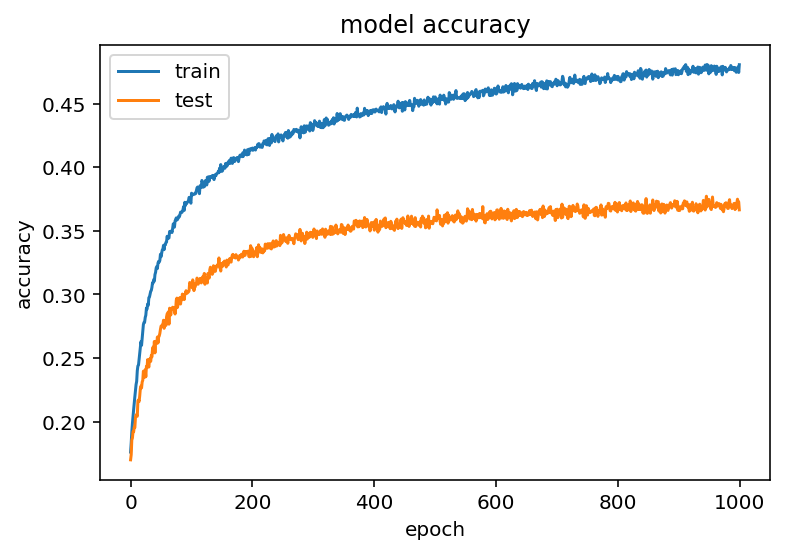

In [114]:
time = datetime.now()
timestampStr = time.strftime("%d %b %Y %H %M %S %f)")
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt

<module 'matplotlib.pyplot' from 'c:\\users\\t-gamer\\documents\\git\\projetointeligenciaartificialsistemasugestao\\gpuvenv\\lib\\site-packages\\matplotlib\\pyplot.py'>

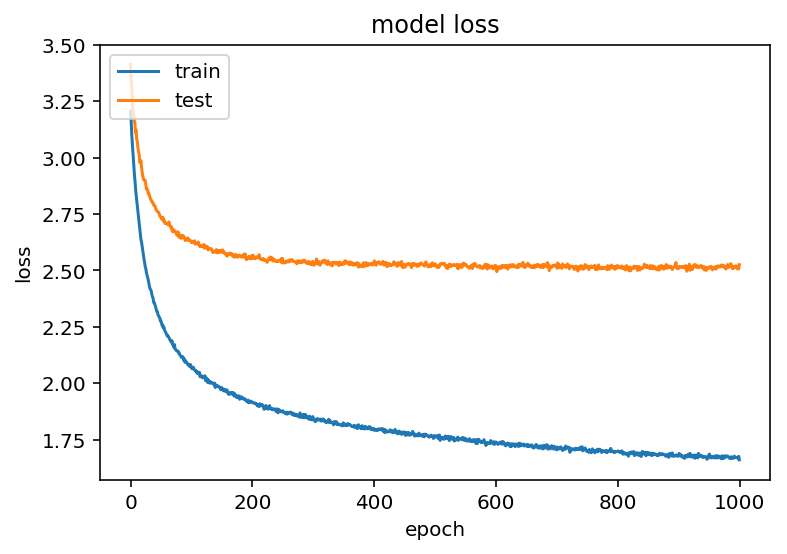

In [115]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("loss"+timestampStr+".png")
plt

In [50]:
#loading best model
model = load_model('best_model.h5')

In [177]:

x_val[np.random.randint(0,len(x_val)-1)]

array([ 61,  92, 135,  65,  18,  59,  63,  95, 109,  82, 101,   8,  92,
        18,  98, 147, 101,   8,  82,  57,  22, 147,  82,   8,  57, 101,
       109,  82,  92, 135,  18,  92])

In [178]:

ind = np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions=[]
for i in range(300):

    random_music = random_music.reshape(1,no_of_timesteps)

    prob  = model.predict(random_music)[0]
    y_pred= np.argmax(prob,axis=0)
    predictions.append(y_pred)

    random_music = np.insert(random_music[0],len(random_music[0]),y_pred)
    random_music = random_music[1:]
    
print(predictions)

[62, 62, 139, 62, 62, 62, 122, 122, 122, 122, 122, 122, 122, 122, 23, 122, 122, 122, 122, 122, 30, 62, 62, 62, 139, 139, 23, 139, 94, 94, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 122, 122, 139, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 102, 102, 164, 122, 164, 127, 100, 122, 122, 127, 17, 17, 17, 17, 17, 17, 17, 17, 130, 17, 17, 17, 139, 17, 17, 17, 139, 17, 17, 17, 17, 17, 106, 106, 106, 106, 106, 17, 106, 106, 17, 11, 153, 139, 106, 62, 62, 62, 62, 62, 62, 106, 62, 106, 60, 23, 23, 62, 72, 94, 94, 94, 94, 94, 165, 94, 94, 139, 165, 102, 139, 62, 4, 23, 122, 23, 122, 122, 122, 122, 122, 122, 110, 122, 122, 122, 122, 139, 122, 139, 122, 139, 122, 139, 139, 139, 139, 139, 139, 24, 165, 139, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 102, 122, 102, 102, 75, 122, 100, 122, 110, 122, 100, 102, 62, 72, 139, 139, 139, 72, 139, 139, 139, 139, 139, 139, 139, 139, 122, 139, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 110

In [179]:
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x)) 
predicted_notes = [x_int_to_note[i] for i in predictions]

In [180]:
def convert_to_midi(prediction_output):
   
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
        else:
            
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='music.mid')

In [181]:
convert_to_midi(predicted_notes)

In [182]:
midi = converter.parse("music.mid")
midi.show()

In [169]:
s3 = instrument.partitionByInstrument(midi)
s3.show()